# MANDATORY ASSIGNMENT 1: LOGISTIC REGRESSION PROBLEM
## Problem: Givet bilens specifikationer, klassificer om den er fuel-efficient

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 2. Load and Explore Data

In [36]:
df = pd.read_csv("data/cars.csv")

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (398, 9)

First 5 rows:
    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  


# 3. Data Cleaning (samme som regression)


In [37]:
df['horsepower'] = df['horsepower'].replace('?', np.nan)
df['horsepower'] = pd.to_numeric(df['horsepower'])

target = "mpg"
features = ["cylinders", "displacement", "horsepower", "weight",
            "acceleration", "model year", "origin"]

df_clean = df[features + [target]].dropna().copy()

print(f"\nRækker i original: {len(df)}")
print(f"Rækker efter dropna: {len(df_clean)}  (fjernet {len(df) - len(df_clean)})")


Rækker i original: 398
Rækker efter dropna: 392  (fjernet 6)


# 4. Create Binary Target Variable


In [38]:
# Vi bruger medianen som threshold for at definere "fuel-efficient"
median_mpg = df_clean[target].median()
print(f"\nMedian MPG: {median_mpg:.1f}")

# Opret binær målvariabel: 1 hvis mpg > median, 0 ellers
df_clean['is_efficient'] = (df_clean[target] > median_mpg).astype(int)

print(f"\nAntal fuel-efficient biler (mpg > {median_mpg:.1f}): {df_clean['is_efficient'].sum()}")
print(f"Antal ikke fuel-efficient biler: {len(df_clean) - df_clean['is_efficient'].sum()}")


Median MPG: 22.8

Antal fuel-efficient biler (mpg > 22.8): 196
Antal ikke fuel-efficient biler: 196


# 5. Prepare Features and Target


In [39]:
X = df_clean[features]
y = df_clean['is_efficient']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 313 samples
Test set: 79 samples


# 5.1 Feature Scaling

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("FØR SCALING (første bil i træningssæt):")
print(X_train.iloc[0].to_string())
print("\nEFTER SCALING (samme bil):")
scaled_series = pd.Series(X_train_scaled[0], index=X_train.columns)
print(scaled_series.to_string())
print("\nFeatures er nu scaled til mean=0, std=1")
print("Dette gør det nemmere for modellen at lære og sammenligne features")

FØR SCALING (første bil i træningssæt):
cylinders          6.0
displacement     225.0
horsepower       110.0
weight          3620.0
acceleration      18.7
model year        78.0
origin             1.0

EFTER SCALING (samme bil):
cylinders       0.304862
displacement    0.284578
horsepower      0.141429
weight          0.754803
acceleration    1.121759
model year      0.494528
origin         -0.689825

Features er nu scaled til mean=0, std=1
Dette gør det nemmere for modellen at lære og sammenligne features


# 6. Train Logistic Regression Model


In [100]:
from sklearn.model_selection import GridSearchCV

print("="*80)
print("HYPERPARAMETER TUNING - Finder de bedste indstillinger")
print("="*80)

# Test forskellige hyperparametre
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      
    'penalty': ['l2'],                  
    'solver': ['lbfgs']                
}

print(f"\nTester {len(param_grid['C'])} forskellige C-værdier: {param_grid['C']}")
print("Med 5-fold cross-validation betyder det 5 × 5 = 25 modeller trænes")

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,              
    scoring='accuracy',
    verbose=1          
)

grid_search.fit(X_train_scaled, y_train)
log_reg = grid_search.best_estimator_

print("\n" + "="*80)
print("RESULTATER")
print("="*80)
print(f"Bedste C-værdi: {grid_search.best_params_['C']}")
print(f"Bedste CV score: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

# Vis alle resultater
print("\nAlle testede C-værdier og deres score:")
results = pd.DataFrame(grid_search.cv_results_)
for c_val, mean_score in zip(results['param_C'], results['mean_test_score']):
    print(f"  C = {c_val:6} → Accuracy: {mean_score:.4f}")

HYPERPARAMETER TUNING - Finder de bedste indstillinger

Tester 5 forskellige C-værdier: [0.01, 0.1, 1, 10, 100]
Med 5-fold cross-validation betyder det 5 × 5 = 25 modeller trænes
Fitting 5 folds for each of 5 candidates, totalling 25 fits

RESULTATER
Bedste C-værdi: 0.01
Bedste CV score: 0.9171 (91.71%)

Alle testede C-værdier og deres score:
  C =   0.01 → Accuracy: 0.9171
  C =    0.1 → Accuracy: 0.9170
  C =    1.0 → Accuracy: 0.9137
  C =   10.0 → Accuracy: 0.9104
  C =  100.0 → Accuracy: 0.9073


# 7. Make Predictions


In [84]:
print("="*80)
print("FORUDSIGELSER PÅ TESTDATA")
print("="*80)

# Lav predictions
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print(f"\nAntal test samples: {len(y_pred)}")
print(f"\nPredictions (0=Not Efficient, 1=Fuel Efficient):")
print(f"  Predicted as Fuel Efficient: {sum(y_pred)} biler ({sum(y_pred)/len(y_pred)*100:.1f}%)")
print(f"  Predicted as NOT Efficient:  {len(y_pred)-sum(y_pred)} biler ({(len(y_pred)-sum(y_pred))/len(y_pred)*100:.1f}%)")

print(f"\nSandsynligheder (0.0-1.0):")
print(f"  Gennemsnitlig confidence: {y_pred_proba.mean():.3f}")
print(f"  Laveste confidence: {y_pred_proba.min():.3f}")
print(f"  Højeste confidence: {y_pred_proba.max():.3f}")

# Vis nogle eksempler
print("\n" + "="*80)
print("EKSEMPEL PREDICTIONS (første 5 testbiler):")
print("="*80)
examples = pd.DataFrame({
    'Actual': y_test.head(5).values,
    'Predicted': y_pred[:5],
    'Probability': y_pred_proba[:5],
    'Correct': ['✓' if a == p else '✗' for a, p in zip(y_test.head(5).values, y_pred[:5])]
})
print(examples.to_string(index=False))

print("\nForklaring:")
print("- Actual: Den rigtige klasse (0 eller 1)")
print("- Predicted: Hvad modellen gættede (0 eller 1)")
print("- Probability: Modellens confidence for klasse 1 (0.0-1.0)")
print("  * >0.5 → predicts 1 (Fuel Efficient)")
print("  * <0.5 → predicts 0 (Not Efficient)")

FORUDSIGELSER PÅ TESTDATA

Antal test samples: 79

Predictions (0=Not Efficient, 1=Fuel Efficient):
  Predicted as Fuel Efficient: 45 biler (57.0%)
  Predicted as NOT Efficient:  34 biler (43.0%)

Sandsynligheder (0.0-1.0):
  Gennemsnitlig confidence: 0.514
  Laveste confidence: 0.028
  Højeste confidence: 0.889

EKSEMPEL PREDICTIONS (første 5 testbiler):
 Actual  Predicted  Probability Correct
      1          1     0.729777       ✓
      0          1     0.674426       ✗
      1          1     0.871926       ✓
      1          1     0.694406       ✓
      1          1     0.710912       ✓

Forklaring:
- Actual: Den rigtige klasse (0 eller 1)
- Predicted: Hvad modellen gættede (0 eller 1)
- Probability: Modellens confidence for klasse 1 (0.0-1.0)
  * >0.5 → predicts 1 (Fuel Efficient)
  * <0.5 → predicts 0 (Not Efficient)


# 8. Evaluate Model


In [97]:
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nI vores {len(y_test)} testbiler har vi:")
print(f"  True Positives (TP):   {tp} - Korrekt fundet som Fuel Efficient")
print(f"  True Negatives (TN):   {tn} - Korrekt fundet som NOT Efficient")
print(f"  False Positives (FP):  {fp} - Forkert kaldt Efficient (var faktisk NOT)")
print(f"  False Negatives (FN):  {fn} - Forkert kaldt NOT Efficient (var faktisk Efficient)")

print("\n" + "-"*80)
print("METRICS:")
print("-"*80)

print(f"\n1. ACCURACY = {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"   ({tp} + {tn}) / {len(y_test)} = {accuracy*100:.1f}% af alle predictions var korrekte")

print(f"\n2. PRECISION = {precision:.3f} ({precision*100:.1f}%)")
print(f"   {tp} / ({tp} + {fp}) = Når vi siger 'Efficient', har vi ret {precision*100:.1f}% af tiden")

print(f"\n3. RECALL = {recall:.3f} ({recall*100:.1f}%)")
print(f"   {tp} / ({tp} + {fn}) = Vi fandt {recall*100:.1f}% af alle Efficient biler")

print(f"\n4. F1-SCORE = {f1:.3f}")
print(f"   Balance mellem precision og recall")



MODEL EVALUATION

I vores 79 testbiler har vi:
  True Positives (TP):   36 - Korrekt fundet som Fuel Efficient
  True Negatives (TN):   33 - Korrekt fundet som NOT Efficient
  False Positives (FP):  9 - Forkert kaldt Efficient (var faktisk NOT)
  False Negatives (FN):  1 - Forkert kaldt NOT Efficient (var faktisk Efficient)

--------------------------------------------------------------------------------
METRICS:
--------------------------------------------------------------------------------

1. ACCURACY = 0.873 (87.3%)
   (36 + 33) / 79 = 87.3% af alle predictions var korrekte

2. PRECISION = 0.800 (80.0%)
   36 / (36 + 9) = Når vi siger 'Efficient', har vi ret 80.0% af tiden

3. RECALL = 0.973 (97.3%)
   36 / (36 + 1) = Vi fandt 97.3% af alle Efficient biler

4. F1-SCORE = 0.878
   Balance mellem precision og recall


# 8.1 Confusion Matrix Visualisering

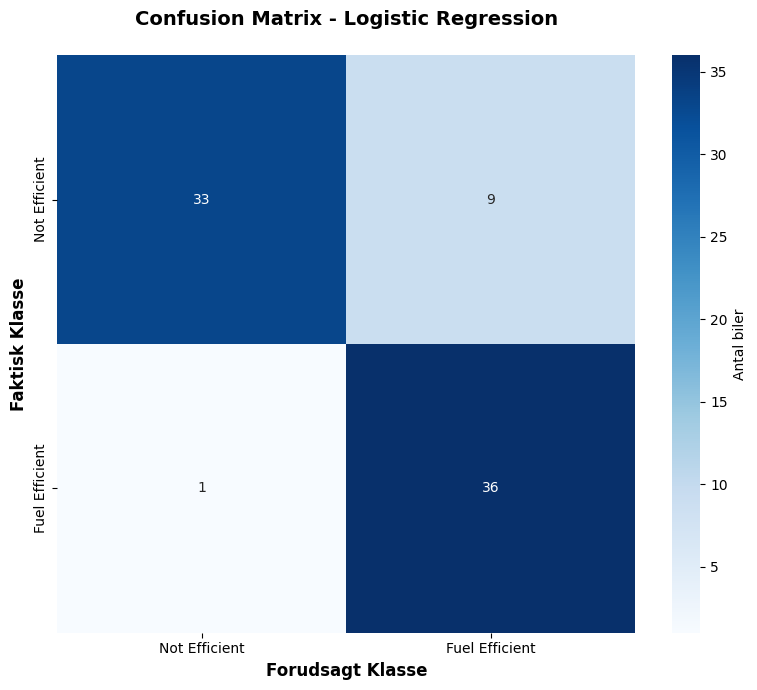


Confusion Matrix viser:
69 korrekte predictions ud af 79 (87.3%)
10 fejl (12.7%)


In [96]:
import seaborn as sns

# Visualiser confusion matrix
plt.figure(figsize=(8, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Efficient', 'Fuel Efficient'],
            yticklabels=['Not Efficient', 'Fuel Efficient'],
            cbar_kws={'label': 'Antal biler'})

plt.title('Confusion Matrix - Logistic Regression\n', fontsize=14, fontweight='bold')
plt.ylabel('Faktisk Klasse', fontsize=12, fontweight='bold')
plt.xlabel('Forudsagt Klasse', fontsize=12, fontweight='bold')

plt.tight_layout()  # Flyttet tight_layout() FØR plt.text()
plt.show()

print("\nConfusion Matrix viser:")
print(f"{tn + tp} korrekte predictions ud af {len(y_test)} ({accuracy*100:.1f}%)")
print(f"{fp + fn} fejl ({(fp+fn)/len(y_test)*100:.1f}%)")

# 8.2 ROC Curve og AUC Score



ROC CURVE ANALYSE
ROC (Receiver Operating Characteristic) viser: Hvor god er modellen til at skelne mellem klasserne?
Vi tester mange forskellige 'thresholds' (ikke bare median=22.8)


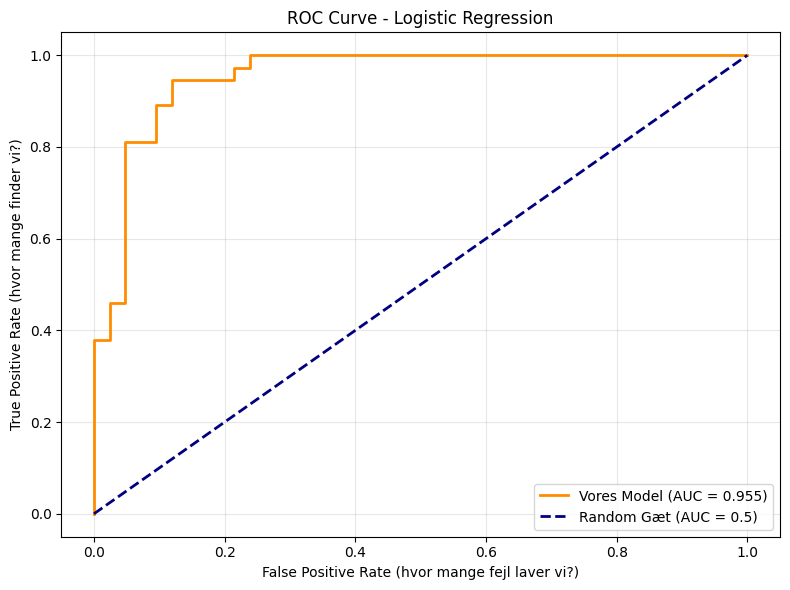


AUC (Area Under Curve) Score: 0.9550

Fortolkning af AUC:
  1.0 = Perfekt model
  0.9 = Excellent
  0.8 = God
  0.5 = Lige så god som at gætte

Vores model med AUC=0.955 er Excellent
  Modellen kan skelne meget godt mellem efficient og NOT efficient biler


In [80]:
from sklearn.metrics import roc_curve, auc

print("\n" + "="*80)
print("ROC CURVE ANALYSE")
print("="*80)
print("ROC (Receiver Operating Characteristic) viser: Hvor god er modellen til at skelne mellem klasserne?")
print(f"Vi tester mange forskellige 'thresholds' (ikke bare median={median_mpg:.1f})")

# Beregn ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Visualiser
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Vores Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Gæt (AUC = 0.5)')
plt.xlabel('False Positive Rate (hvor mange fejl laver vi?)')
plt.ylabel('True Positive Rate (hvor mange finder vi?)')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC (Area Under Curve) Score: {roc_auc:.4f}")
print("\nFortolkning af AUC:")
print("  1.0 = Perfekt model")
print("  0.9 = Excellent")
print("  0.8 = God")
print("  0.5 = Lige så god som at gætte")

if roc_auc >= 0.9:
    print(f"\nVores model med AUC={roc_auc:.3f} er Excellent")
    print("  Modellen kan skelne meget godt mellem efficient og NOT efficient biler")
elif roc_auc >= 0.8:
    print(f"\nVores model med AUC={roc_auc:.3f} er GOD")

# 9. Model Validation - Sammenligning med Træningsdata


In [81]:
print("\n" + "="*80)
print("MODEL VALIDATION")
print("="*80)

# Tjek overfitting
y_train_pred = log_reg.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Træning Accuracy: {train_accuracy:.3f} ({train_accuracy*100:.1f}%)")
print(f"Test Accuracy:    {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Forskel:          {abs(train_accuracy - accuracy):.3f} ({abs(train_accuracy - accuracy)*100:.1f}%)")

if abs(train_accuracy - accuracy) < 0.05:
    print("God generalisering - modellen overfitter ikke")

print(f"\nGridSearchCV brugte 5-fold CV → Best score: {grid_search.best_score_:.3f}")


MODEL VALIDATION
Træning Accuracy: 0.917 (91.7%)
Test Accuracy:    0.873 (87.3%)
Forskel:          0.044 (4.4%)
God generalisering - modellen overfitter ikke

GridSearchCV brugte 5-fold CV → Best score: 0.917


# 10. Feature Importance (Coefficients)


In [46]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE (Koefficienter)")
print("="*80)
print(feature_importance.to_string(index=False))
print("\nPositive koefficienter øger sandsynligheden for fuel-efficient")
print("Negative koefficienter mindsker sandsynligheden for fuel-efficient")


FEATURE IMPORTANCE (Koefficienter)
     Feature  Coefficient
  model year     0.272619
      origin     0.219132
acceleration     0.074588
  horsepower    -0.266026
displacement    -0.320244
   cylinders    -0.332859
      weight    -0.357700

Positive koefficienter øger sandsynligheden for fuel-efficient
Negative koefficienter mindsker sandsynligheden for fuel-efficient
